In [16]:
import sys
sys.path.append('../build/')
%pylab inline
np.set_printoptions(precision=4, suppress=True)
from motor_estimation import MotorEstimationSolver
import pandas as pd
import linear_solver
from linear_solver import expm, logm
import versor as vsr

Populating the interactive namespace from numpy and matplotlib


In [17]:
def S(v):
    return np.array([[0,-v[2],v[1]],
                     [v[2], 0, -v[0]], 
                     [-v[1],v[0], 0]])

In [18]:
E1 = S([1,0,0])
E2 = S([0,1,0])
E3 = S([0,0,1])

In [71]:
n_vs = 10
vs = [(lambda x: x / np.linalg.norm(x))(np.random.random((3,1))) for i in range(n_vs)]
us = [R0 @ v for v in vs]
# us = [(lambda x: x / np.linalg.norm(x))(np.dot(R0,v) + 
#                                         np.random.normal(loc=0.0,
#                                                          scale=0.01,
#                                                          size=(3,1)))  for v in vs]

In [72]:
def df_R(u, v, B,R):
    return (2 * (u.T @ R @ B @ v) * (u.T @ R @ v)).ravel()

In [73]:
def grad(us,vs,R):
    g = np.sum([np.array([df_R(u,v,E1,R), 
                          df_R(u,v,E2,R), 
                          df_R(u,v,E3,R)]) for u,v in zip(us,vs)],axis=0)
    return g

In [74]:
def Hessij(us, vs, Bi, Bj, R):
    X = R @ Bi
    Y = R @ Bj
    return np.sum([2 * u.T @ X @ v @ u.T @ Y @ v +
                   u.T @ R @ v @ u.T @ X @ R.T @ Y @ v +
                   u.T @ R @ v @ u.T @ Y @ R.T @ X @ v
                   for u, v in zip(us, vs)])

In [75]:
def Hess(us, vs, R):
    H = np.zeros((3,3))
    H[0,0] = Hessij(us, vs, E1, E1, R)
    H[0,1] = H[1,0] = Hessij(us, vs, E1, E2, R)
    H[0,2] = H[2,0] = Hessij(us, vs, E1, E3, R)
    H[1,1] = Hessij(us, vs, E2, E2, R)
    H[1,2] = H[2,1] = Hessij(us, vs, E2, E3, R)
    H[2,2] = Hessij(us, vs, E3, E3, R)
    return H

In [76]:
def cost(us, vs, R):
    x = [(np.dot(np.dot(u.T,R),v))**2 for u,v in zip(us, vs)]
    return np.sum(x)

In [77]:
def update(us, vs, R):
    H = Hess(us, vs, R)
    g = grad(us, vs, R) 
    B = -linear_solver.solve(H,g)    
    R = R @ expm(S(B))
    c = cost(us, vs, R)
    return R, c, norm(B)

In [78]:
ns = []
cs = []
Rstart = np.eye(3)
R, c, n = update(us, vs, Rstart)
ns.append(n)
cs.append(c)
# for i in range(100):
while n > 1e-3:
    R, c, n = update(us, vs, R)
    ns.append(n)
    cs.append(c)

print(R0.T @ R)

[[ 1.  0. -0.]
 [-0.  1.  0.]
 [ 0. -0.  1.]]


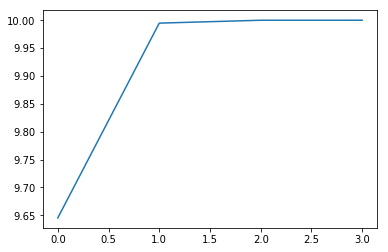

In [79]:
plot(cs)

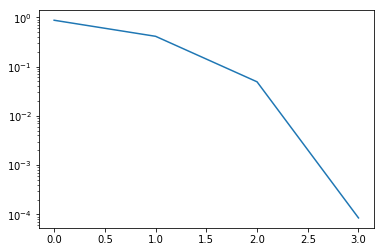

In [80]:
semilogy(ns)